# 实验说明
1. 通过对DNN与CNN对KDD99入侵检测数据集的分类，探究DNN与CNN模型对其分类的准确度
2. 实验过程分为数据预处理、定义训练参数、DNN分类、CNN分类

In [10]:
import os

import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# 1 数据预处理
## 1.1 pandas导入数据

In [11]:
df = pd.read_csv('/root/dataset/kddcup.data_10_percent_corrected')

In [12]:
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'label'
]

In [13]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


## 1.2 one-hot编码

In [14]:
# 数值列
number_col = df.select_dtypes(include=['number']).columns
# 分类变量
cat_col = df.columns.difference(number_col)
cat_col = cat_col.drop('label')
# 将分类变量筛选出来
df_cat = df[cat_col].copy()

In [15]:
# one-hot编码
one_hot_data = pd.get_dummies(df_cat, columns=cat_col)

# 将原数据的分类变量去掉
one_hot_df = pd.concat([df, one_hot_data],axis=1)
one_hot_df.drop(columns=cat_col, inplace=True)

In [16]:
one_hot_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois
0,0,239,486,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,0,235,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
2,0,219,1337,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
3,0,217,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
4,0,217,2032,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,310,1881,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
494016,0,282,2286,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
494017,0,203,1200,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False
494018,0,291,1200,0,0,0,0,0,1,0,...,False,False,False,False,False,False,False,False,False,False


## 1.3 归一化

In [17]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))

def normalization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
    return df

In [18]:
normalized_df = normalization(one_hot_df.copy(), number_col)
normalized_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois
0,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0.0,4.470881e-07,0.000365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
494016,0.0,4.067060e-07,0.000443,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
494017,0.0,2.927706e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
494018,0.0,4.196859e-07,0.000233,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,False,False


## 1.4 标签编码

In [19]:
# 为不同的类别进行编码
labels = pd.DataFrame(df.label)
label_encoder = LabelEncoder()
enc_label = labels.apply(label_encoder.fit_transform)
normalized_df.label = enc_label
label_encoder.classes_

array(['back.', 'buffer_overflow.', 'ftp_write.', 'guess_passwd.',
       'imap.', 'ipsweep.', 'land.', 'loadmodule.', 'multihop.',
       'neptune.', 'nmap.', 'normal.', 'perl.', 'phf.', 'pod.',
       'portsweep.', 'rootkit.', 'satan.', 'smurf.', 'spy.', 'teardrop.',
       'warezclient.', 'warezmaster.'], dtype=object)

In [20]:
data = normalized_df

# 2 定义训练参数
## 2.1 数据加载

In [21]:
X = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)

In [22]:
class LoadData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = torch.tensor(self.X.iloc[index])
        y = torch.tensor(self.y.iloc[index])
        return X, y

In [23]:
train_data = LoadData(X_train, y_train)
test_data = LoadData(X_test, y_test)

In [24]:
X_dimension = len(X_train.columns)
y_dimension = len(y_train.value_counts())
print(f"X的维度：{X_dimension}")
print(f"y的维度：{y_dimension}")

X的维度：118
y的维度：23


In [25]:
batch_size = 128

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## 2.2 训练函数与测试函数

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [27]:
def train(model, optimizer, loss_fn, epochs):

    losses = []
    iter = 0

    for epoch in range(epochs):
        print(f"epoch {epoch+1}\n-----------------")
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            X = X.reshape(X.shape[0], 1, X_dimension)
            y_pred = model(X)
            loss = loss_fn(y_pred, y.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"loss: {loss.item()}\t[{(i+1)*len(X)}/{len(train_data)}]")

                iter += 1
                losses.append(loss.item())

    return losses, iter

In [28]:
def test(model):
    positive = 0
    negative = 0
    with torch.no_grad():
        iter = 0
        loss_sum = 0
        for X, y in test_dataloader:
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            X = X.reshape(X.shape[0], 1, X_dimension)
            y_pred = model(X)
            loss = loss_fn(y_pred, y.long())
            loss_sum += loss.item()
            iter += 1
            for item in zip(y_pred, y):
                if torch.argmax(item[0]) == item[1]:
                    positive += 1
                else:
                    negative += 1
    acc = positive / (positive + negative)
    avg_loss = loss_sum / iter
    print("Accuracy:", acc)
    print("Average Loss:", avg_loss)

In [29]:
def loss_value_plot(losses, iter):
    plt.figure()
    plt.plot([i for i in range(1, iter+1)], losses)
    plt.xlabel('Iterations (×100)')
    plt.ylabel('Loss Value')

# 2 DNN分类

In [30]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(X_dimension, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, y_dimension)
        )

    def forward(self, X):
        X = self.flatten(X)
        logits = self.network(X)
        return logits

In [31]:
DNN_model = DNN()
DNN_model.to(device=device)

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=118, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=23, bias=True)
  )
)

In [32]:
# 超参数
epochs = 5
lr = 1e-3
momentum = 0.9
optimizer = torch.optim.SGD(DNN_model.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()

epoch 1
-----------------
loss: 3.1012020111083984	[128/395216]


loss: 2.348965883255005	[12928/395216]
loss: 1.2527861595153809	[25728/395216]
loss: 0.8434427380561829	[38528/395216]
loss: 0.8071912527084351	[51328/395216]
loss: 0.3926984667778015	[64128/395216]
loss: 0.4178600311279297	[76928/395216]
loss: 0.2722310423851013	[89728/395216]
loss: 0.3047427535057068	[102528/395216]
loss: 0.14802001416683197	[115328/395216]
loss: 0.21182429790496826	[128128/395216]
loss: 0.2886735796928406	[140928/395216]
loss: 0.14976200461387634	[153728/395216]
loss: 0.03524661064147949	[166528/395216]
loss: 0.08113865554332733	[179328/395216]
loss: 0.11875761300325394	[192128/395216]
loss: 0.1228792667388916	[204928/395216]
loss: 0.06991615891456604	[217728/395216]
loss: 0.07614780217409134	[230528/395216]
loss: 0.21616169810295105	[243328/395216]
loss: 0.2501181960105896	[256128/395216]
loss: 0.09189093112945557	[268928/395216]
loss: 0.19378779828548431	[281728/395216]
loss: 0.02407553791999817	[294528/395216]
loss: 0.055196210741996765	[307328/395216]
loss: 0.15

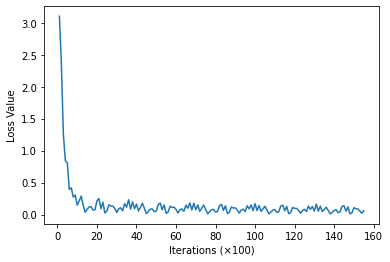

In [33]:
if os.path.exists('DNN_model.pth'):
    DNN_model.load_state_dict(torch.load('DNN_model.pth'))
else:
    losses, iter = train(DNN_model, optimizer, loss_fn, epochs)
    torch.save(DNN_model.state_dict(), 'DNN_model.pth')

    loss_value_plot(losses, iter)
    plt.savefig('DNN_loss.png')

In [34]:
test(DNN_model)

Accuracy: 0.9837354762965063
Average Loss: 0.06714473901632594


# 3 CNN分类

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv1d(1, 3, kernel_size=2),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(3, 8, kernel_size=2),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(8, 16, kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(432, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, y_dimension)
        )

    def forward(self, X):
        X = self.backbone(X)
        X = self.flatten(X)
        logits = self.fc(X)
        return logits

In [36]:
CNN_model = CNN()
CNN_model.to(device=device)

CNN(
  (backbone): Sequential(
    (0): Conv1d(1, 3, kernel_size=(2,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(3, 8, kernel_size=(2,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=432, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=23, bias=True)
  )
)

In [37]:
epochs = 2
lr = 1e-3
momentum = 0.9
optimizer = torch.optim.SGD(CNN_model.parameters(), lr=lr, momentum=momentum)
loss_fn = nn.CrossEntropyLoss()

epoch 1
-----------------
loss: 3.032839059829712	[128/395216]


loss: 1.9856219291687012	[12928/395216]
loss: 1.1636406183242798	[25728/395216]
loss: 1.0679346323013306	[38528/395216]
loss: 1.2448333501815796	[51328/395216]
loss: 0.9402050971984863	[64128/395216]
loss: 0.959216296672821	[76928/395216]
loss: 0.7506988644599915	[89728/395216]
loss: 0.4494873285293579	[102528/395216]
loss: 0.14808085560798645	[115328/395216]
loss: 0.1702025830745697	[128128/395216]
loss: 0.23027008771896362	[140928/395216]
loss: 0.1271643191576004	[153728/395216]
loss: 0.03025115095078945	[166528/395216]
loss: 0.06974820047616959	[179328/395216]
loss: 0.09674732387065887	[192128/395216]
loss: 0.0930490493774414	[204928/395216]
loss: 0.05160567909479141	[217728/395216]
loss: 0.07950224727392197	[230528/395216]
loss: 0.16766466200351715	[243328/395216]
loss: 0.1715359389781952	[256128/395216]
loss: 0.08101436495780945	[268928/395216]
loss: 0.15359699726104736	[281728/395216]
loss: 0.0168056171387434	[294528/395216]
loss: 0.03895873576402664	[307328/395216]
loss: 0.12240

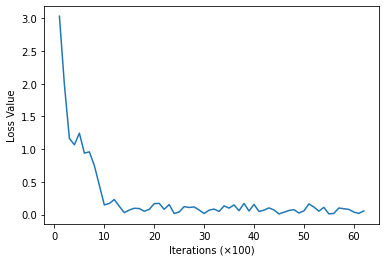

In [38]:
if os.path.exists('CNN_model.pth'):
    CNN_model.load_state_dict(torch.load('CNN_model.pth'))
else:
    losses, iter = train(CNN_model, optimizer, loss_fn, epochs)
    torch.save(CNN_model.state_dict(), 'CNN_model.pth')

    loss_value_plot(losses, iter)
    plt.savefig('CNN_loss.png')

In [39]:
test(CNN_model)

Accuracy: 0.9859722278450265
Average Loss: 0.057980522857810045
